# Importing Libraries

* System Append to set proper path

In [1]:
sys.path.append('../')

* Default

In [2]:
import lasio
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
import time
import multiprocessing

* Pandas Options

In [3]:
pd.set_option('max_columns', None)

* Source Code

In [4]:
from Source.Utils import welllog
from Source.Utils import multi_df
from Source.Utils import well_plot

* Tqdm Progress Bar

In [5]:
%%capture
from tqdm import tqdm_notebook

# Reading Miscellaneous Data

In [6]:
file_path = '../Data/Lithology code data.xlsx'

litho_code = pd.read_excel(file_path)

* Lithology Code 

In [7]:
litho_code.head(n=2)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,Lithology,Color,Lithology Attribute,Abbreviation
1,Aeolian Sandstone,LightYellow,CrossBedded Sand,35


        * Fixing Columns IDs

In [8]:
litho_code.columns = litho_code.iloc[0]

        * Droping first row (as it has become the columns ids now)

In [9]:
litho_code.drop(index=0, inplace=True)

        * Checking Final Result

In [10]:
litho_code.head(n=2)

,Lithology,Color,Lithology Attribute,Abbreviation
1,Aeolian Sandstone,LightYellow,CrossBedded Sand,35
2,Anhydrite,Light Magenta,Anhydrite,22


# Reading Las files Dataset

In [11]:
path = '../Data/GEOLINK_Lithology and wells NORTH SEA/'

npd_wells = welllog.read_las_directory(path)

* Las files Glance

In [12]:
print('Number of Las Files read: ' + str(len(npd_wells)))
print('##########################')
print('Las files ID: ' + str(npd_wells.keys()))
print('##########################')
print(str(npd_wells['15_9-12'].curves))


Number of Las Files read: 223
##########################
Las files ID: dict_keys(['25_7-2', '25_5-4', '25_10-2 R', '33_6-2', '31_5-3', '35_8-1', '15_9-17', '34_12-1', '30_2-2', '15_9-23', '34_10-18', '35_9-8', '31_5-2 R', '16_7-8 S', '31_4-2', '34_4-10 R', '30_6-5', '34_10-16 R', '35_3-4', '35_11-9', '35_11-11', '35_8-3', '34_7-20', '35_8-5 S', '34_3-1 A', '31_2-21 S', '30_7-7', '31_2-10', '25_2-13 T4', '31_4-5', '31_5-6', '30_9-13 S', '34_11-3 T2', '25_8-1', '35_3-2', '34_10-19', '31_2-17 A', '16_10-4', '30_6-14', '34_2-4', '35_11-1', '16_1-2', '15_9-22', '35_3-1', '30_2-1', '25_6-2', '30_3-2 R', '25_2-14', '25_10-4 R', '35_9-1', '16_10-2', '34_2-2 R', '31_2-2 R', '16_7-1', '30_3-5 S', '24_12-2', '25_11-24', '16_5-3', '34_4-5', '30_6-8', '25_10-10', '36_7-1', '34_10-17', '34_7-16', '30_6-23', '31_4-10', '17_4-1', '25_10-8 A', '30_3-4 R', '25_4-5', '16_8-1', '34_7-5', '15_9-13', '35_8-4', '31_2-8', '25_6-3', '15_9-15', '31_2-7', '15_9-2', '16_7-6', '34_4-2', '25_11-23', '34_10-35', '34

        Note: The Mnmonic Table above does not necessarily represent all the available log curves on the dataset

# Main Dataframe Building and Processing

* Checking unmatching unit of measurement for each log curve

In [13]:
unit_mismatch_list = welllog.unit_check(npd_wells)




It was found a total of 0 unmatching unit of measurement in the dataset. Please, check the flag output for proper adjustments


* Converting all las files to dataframe

In [14]:
npd_wells_df = {}

for id in tqdm_notebook(list(npd_wells.keys()), desc='Converting to dataframe'):

    npd_wells_df[id] = npd_wells[id].df()

* Creating Main Dataframe

        * Creating Well ID column

In [15]:
for id in tqdm_notebook(list(npd_wells_df.keys()), desc='Adding Well Name Column'):

    npd_wells_df[id]['WELL_NAME'] = id

        * Converting Depth to a Column

In [16]:
for id in tqdm_notebook(list(npd_wells_df.keys()), desc='Adding Depth Column'):

    npd_wells_df[id]['DEPTH'] = npd_wells_df[id].index

        * Analyzing the balance of logs by well

In [17]:
wlist = list(npd_wells_df.keys())

unique_logs = []

for i in tqdm_notebook(wlist, desc= 'Searching Logs'):

    temp = npd_wells_df[i].columns

    unique_logs.extend(temp)

unique_logs = list(set(unique_logs))

print('List of unique logs: ', unique_logs, '\n')
print('Number of unique logs: ', len(unique_logs))


List of unique logs:  ['ROP', 'DTC', 'SP', 'THOR', 'SGR', 'URAN', 'DRHO', 'DEPTH', 'RDEP', 'RMIC', 'DTE', 'CGR', 'RMED', 'PEF', 'RXO', 'DCAL', 'RHOM', 'LITHOLOGY_GEOLINK', 'BS', 'NPHI', 'GR', 'DTS', 'MUDWEIGHT', 'WELL_NAME', 'TGAS', 'DT', 'CALI', 'RSHA', 'RHOB'] 

Number of unique logs:  29


In [18]:
log_dict = dict.fromkeys(unique_logs, 0)

for l in tqdm_notebook(log_dict.keys(), desc='Counting Logs'):
    
    for w in npd_wells_df.keys():

        if l in npd_wells_df[w].columns:

            log_dict[l] = log_dict[l] + 1

In [19]:
log_df = pd.DataFrame(log_dict.items(), columns=['logs', 'count'])

log_df['percent'] = (log_df['count'] / 223)*100

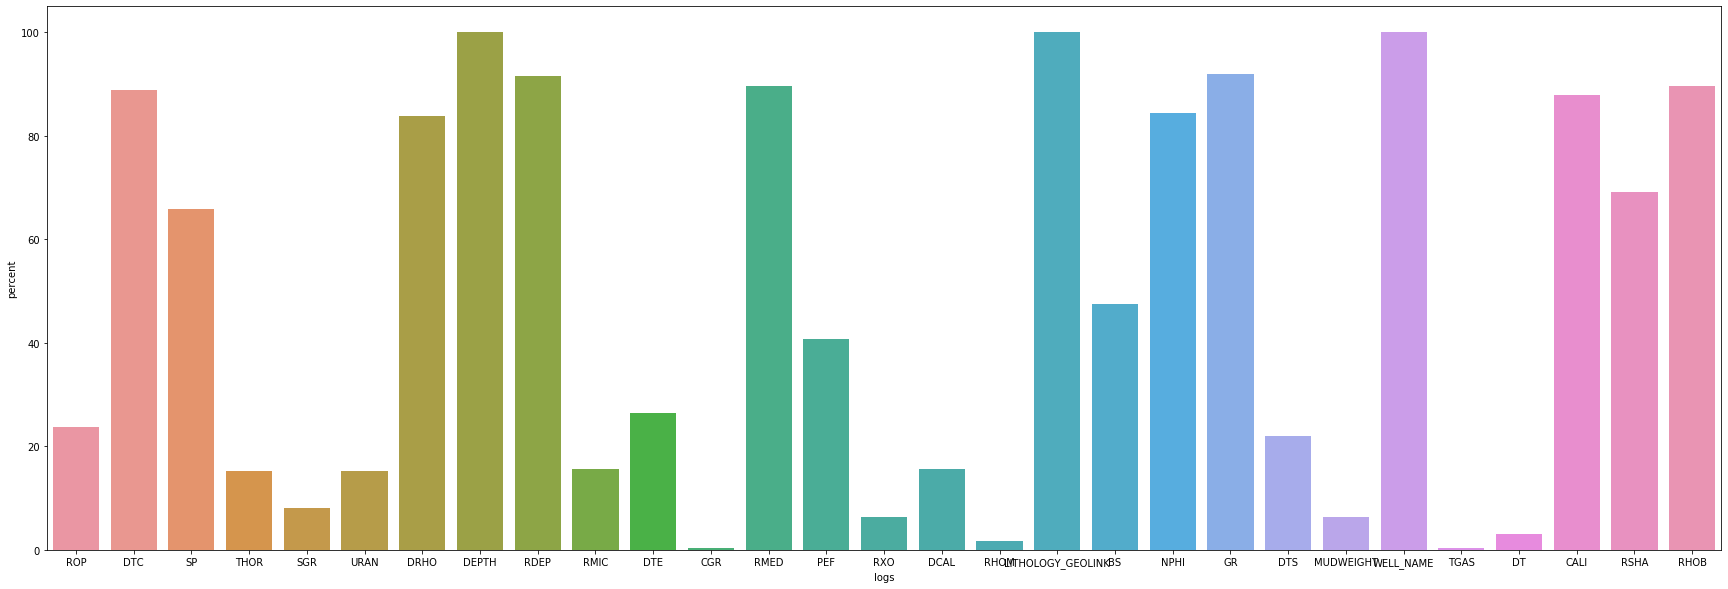

In [20]:
plt.figure(figsize=(30,10))
sns.barplot(x='logs', y='percent', data=log_df)

        * Selected Logs

In [21]:
logs_list = ['DEPTH','LITHOLOGY_GEOLINK', 'CALI', 'NPHI', 'RHOB', 'GR', 'DTC', 'RDEP', 'RMED', 'WELL_NAME']


        * Creating Empty Dataframe

In [22]:
df_main = pd.DataFrame(columns= logs_list)

        * Filling Dataframe

In [23]:
for id in tqdm_notebook(list(npd_wells_df.keys()), desc='Filling Dataframe'):

    tmp = []

    for i in range(len(logs_list)):

        if logs_list[i] in npd_wells_df[id].columns:

            tmp.append(logs_list[i])

    df_main = df_main.append(npd_wells_df[id][tmp], ignore_index=True)     

In [24]:
len(df_main) # number of samples

3147162

## Exploratory Data Analysis

* Correlation Matrix

(8.9, -0.5)

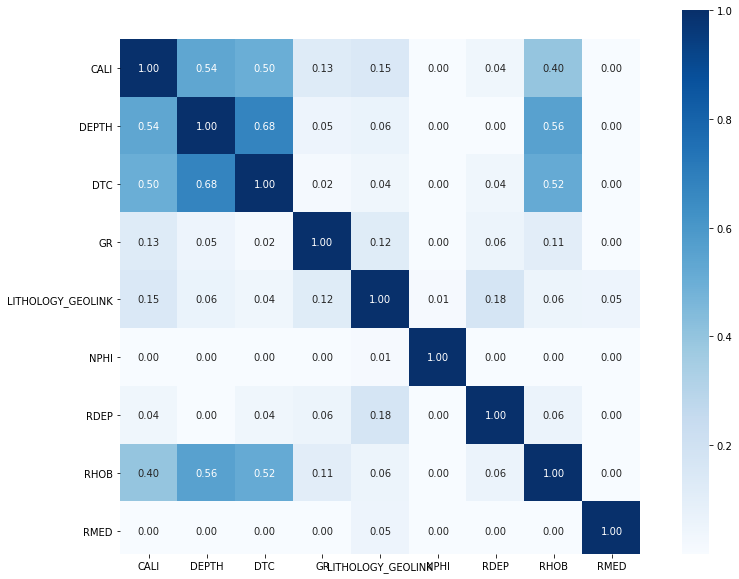

In [25]:
corrmat_df = abs(df_main.corr()) # absolute correlation

fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(corrmat_df, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, cmap='Blues')

ax.set_ylim(len(corrmat_df)-0.1, -0.5)

* General Statistics

In [26]:
df_main.describe()

,CALI,DEPTH,DTC,GR,LITHOLOGY_GEOLINK,NPHI,RDEP,RHOB,RMED
count,2.942514e+06,3.147162e+06,2.936687e+06,3.108057e+06,1.650950e+06,1.894092e+06,3.073558e+06,2.774715e+06,2.944318e+06
mean,1.342559e+01,2.178031e+03,1.141344e+02,6.598313e+01,7.425249e+00,1.751375e+00,3.263110e+01,2.273573e+00,5.127361e+01
std,4.065481e+00,1.038157e+03,3.454971e+01,4.916798e+01,4.628714e+00,1.408550e+02,4.901243e+02,3.268230e-01,2.809883e+04
min,-9.834000e+00,8.015202e+01,-3.102476e+02,-9.990000e+02,1.000000e+00,-1.009700e-01,-9.999000e+03,-1.984000e+00,-4.230000e-01
25%,1.026520e+01,1.368847e+03,8.761197e+01,4.426330e+01,5.000000e+00,2.254500e-01,9.240000e-01,2.083600e+00,9.133000e-01
50%,1.284234e+01,2.088328e+03,1.116960e+02,6.287677e+01,6.000000e+00,3.220202e-01,1.455498e+00,2.291000e+00,1.459000e+00
75%,1.722600e+01,2.912315e+03,1.432239e+02,8.396545e+01,1.100000e+01,4.248798e-01,2.552900e+00,2.481900e+00,2.642121e+00
max,4.063500e+01,5.477854e+03,9.881560e+02,3.279053e+04,3.400000e+01,1.530410e+05,7.450856e+04,1.916629e+02,1.968300e+07


* Classes balance

Text(0.5, 1.0, 'Lithology Classes - Target Variable Balance')

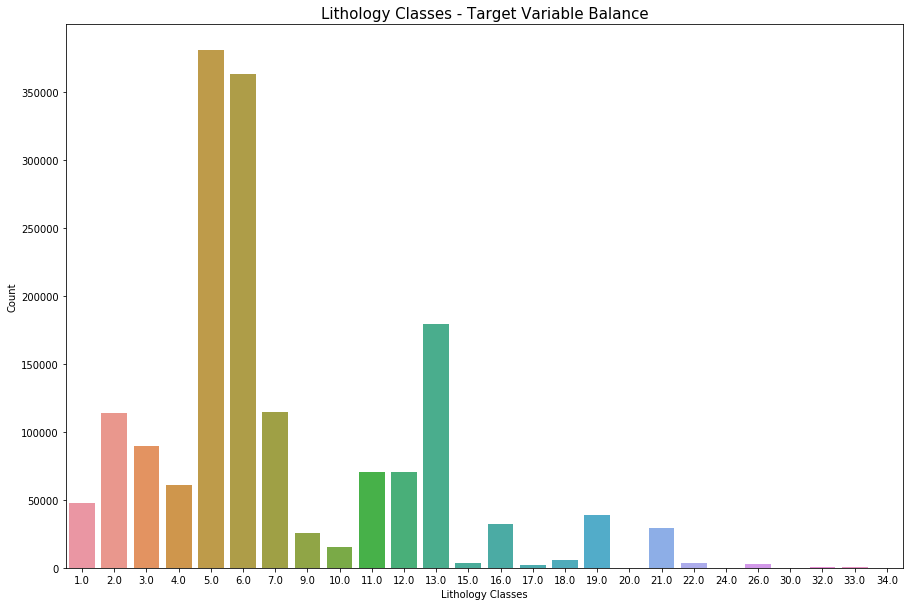

In [27]:
plt.figure(figsize=(15,10))

sns.barplot(x=df_main['LITHOLOGY_GEOLINK'].value_counts().index, y=df_main['LITHOLOGY_GEOLINK'].value_counts())
plt.xlabel('Lithology Classes', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Lithology Classes - Target Variable Balance', fontsize=15)

* Distribution Information

        * Lithology_Geolink Variable

In [28]:
(mu, sigma) = stats.norm.fit(df_main[df_main.LITHOLOGY_GEOLINK.notnull()].LITHOLOGY_GEOLINK.values) 

Text(0.5, 1.0, 'LITHOLOGY_GEOLINK distribution -- Mu: 7.425249099003604 Sigma: 4.628712679162474')

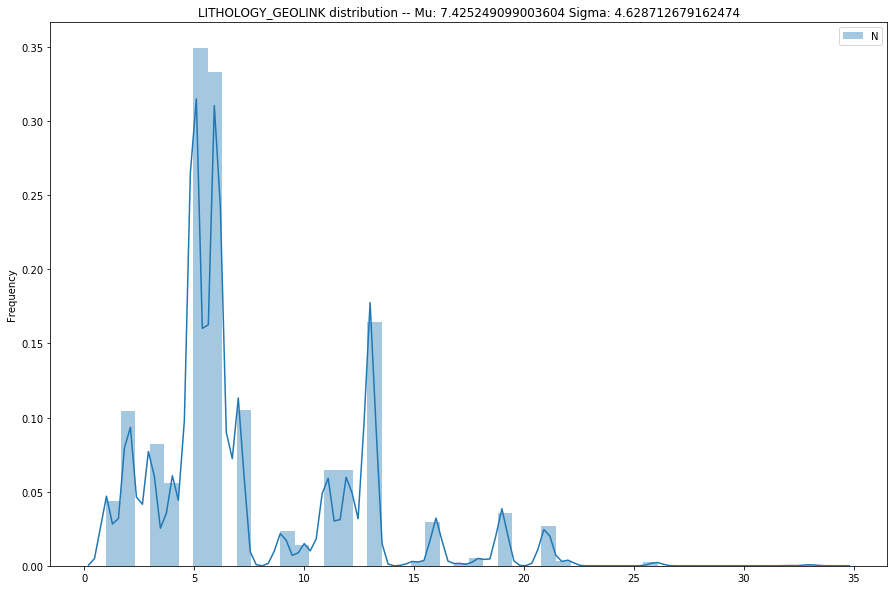

In [29]:
plt.figure(figsize=(15,10))

sns.distplot(df_main[df_main.LITHOLOGY_GEOLINK.notnull()].LITHOLOGY_GEOLINK.values); 

plt.legend('Normal distribution')
plt.ylabel('Frequency')
plt.title('LITHOLOGY_GEOLINK distribution -- Mu:' + ' ' + str(mu) + ' ' + 'Sigma:' + ' ' + str(sigma) )

        * CALI Variable 

In [30]:
(mu, sigma) = stats.norm.fit(df_main[df_main.CALI.notnull()].CALI.values) 

Text(0.5, 1.0, 'CALI distribution -- Mu: 13.425588561720584 Sigma: 4.065480440686085')

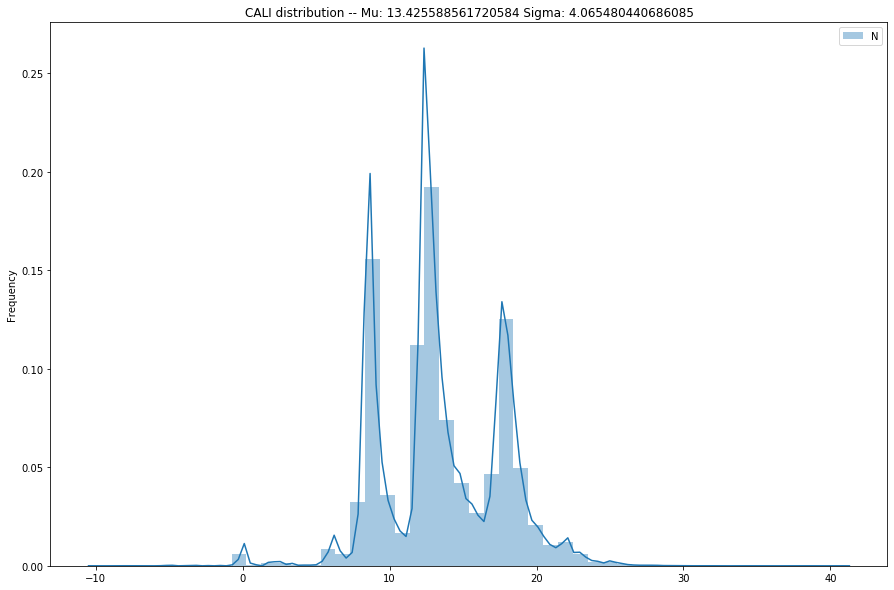

In [31]:
plt.figure(figsize=(15,10))

sns.distplot(df_main[df_main.CALI.notnull()].CALI.values); 

plt.legend('Normal distribution')
plt.ylabel('Frequency')
plt.title('CALI distribution -- Mu:' + ' ' + str(mu) + ' ' + 'Sigma:' + ' ' + str(sigma) )

        * NPHI Variable

In [32]:
(mu, sigma) = stats.norm.fit(df_main[df_main.NPHI.notnull()].NPHI.values) 

Text(0.5, 1.0, 'NPHI distribution -- Mu: 1.7513748869027608 Sigma: 140.85491998603123')

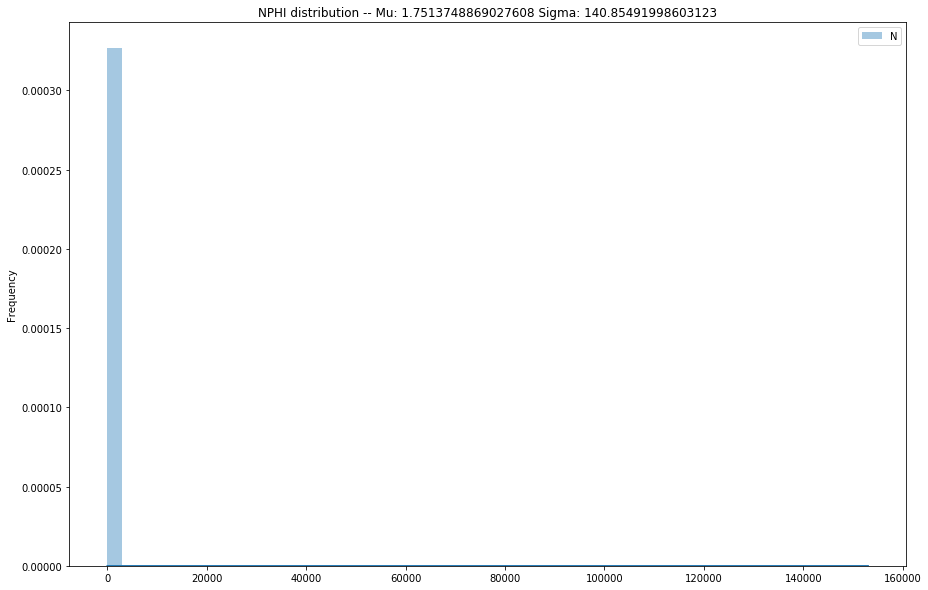

In [33]:
plt.figure(figsize=(15,10))

sns.distplot(df_main[df_main.NPHI.notnull()].NPHI.values);
#plt.xlim(0,100) 

plt.legend('Normal distribution')
plt.ylabel('Frequency')
plt.title('NPHI distribution -- Mu:' + ' ' + str(mu) + ' ' + 'Sigma:' + ' ' + str(sigma) )

* Converting NPHI values from % to integers

In [34]:
multiprocessing.set_start_method('spawn', True)

start_time = time.time()

NUM_CORES = 60

df_chunks_out_count = np.array_split(df_main, NUM_CORES)

with multiprocessing.Pool(NUM_CORES) as pool:

    df_main = pd.concat(pool.map(multi_df.nphi_filtering, df_chunks_out_count), ignore_index=True)

print(str(round((time.time() - start_time)/60,1)) + ' minutes taken') 

6.8 minutes taken


        * RHOB Variable

In [35]:
(mu, sigma) = stats.norm.fit(df_main[df_main.RHOB.notnull()].RHOB.values) 

Text(0.5, 1.0, 'RHOB distribution -- Mu: 2.273572871556706 Sigma: 0.3268229686339855')

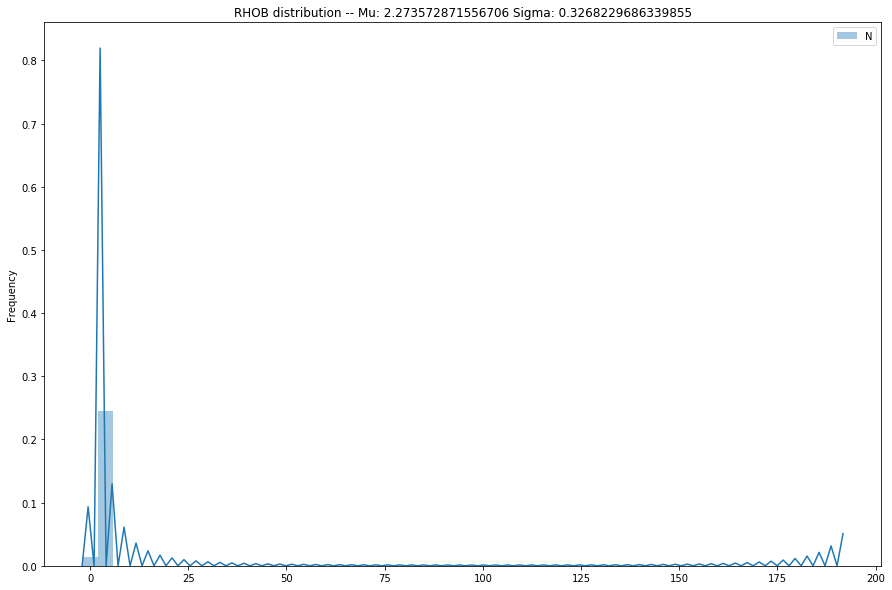

In [36]:
plt.figure(figsize=(15,10))

sns.distplot(df_main[df_main.RHOB.notnull()].RHOB.values); 

plt.legend('Normal distribution')
plt.ylabel('Frequency')
plt.title('RHOB distribution -- Mu:' + ' ' + str(mu) + ' ' + 'Sigma:' + ' ' + str(sigma) )

        * GR Variable

In [37]:
(mu, sigma) = stats.norm.fit(df_main[df_main.GR.notnull()].GR.values) 

Text(0.5, 1.0, 'GR distribution -- Mu: 65.98312764328183 Sigma: 49.16797350587903')

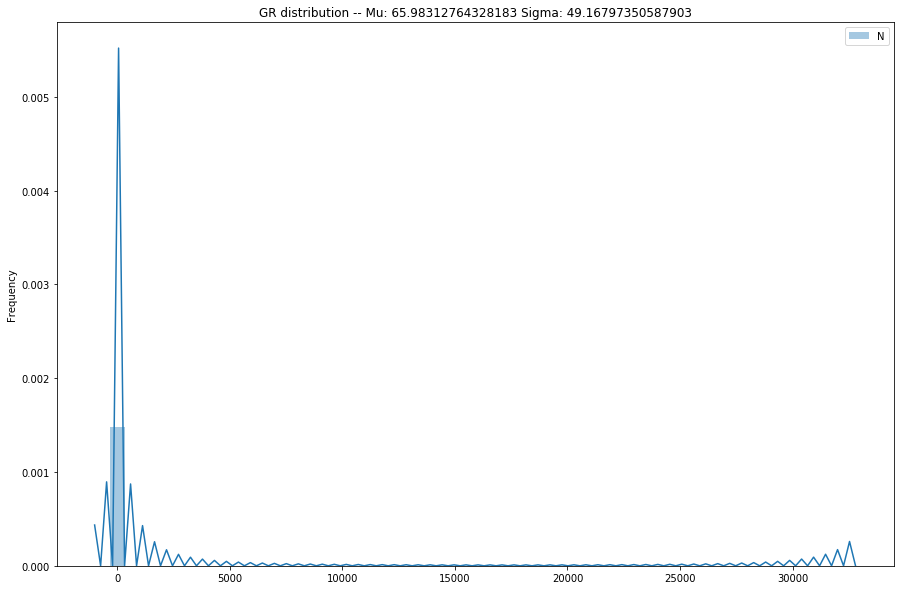

In [38]:
plt.figure(figsize=(15,10))

sns.distplot(df_main[df_main.GR.notnull()].GR.values); 

plt.legend('Normal distribution')
plt.ylabel('Frequency')
plt.title('GR distribution -- Mu:' + ' ' + str(mu) + ' ' + 'Sigma:' + ' ' + str(sigma) )

        * DTC Variable

In [39]:
(mu, sigma) = stats.norm.fit(df_main[df_main.DTC.notnull()].DTC.values) 

Text(0.5, 1.0, 'DTC distribution -- Mu: 114.13437651654671 Sigma: 34.54969923736454')

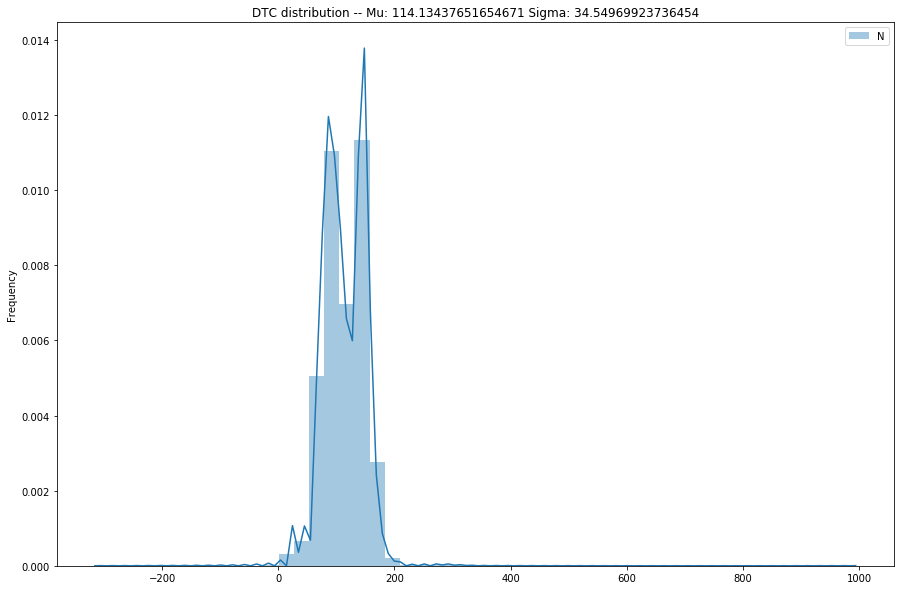

In [40]:
plt.figure(figsize=(15,10))

sns.distplot(df_main[df_main.DTC.notnull()].DTC.values); 

plt.legend('Normal distribution')
plt.ylabel('Frequency')
plt.title('DTC distribution -- Mu:' + ' ' + str(mu) + ' ' + 'Sigma:' + ' ' + str(sigma) )

        * RDEP Variable

In [41]:
(mu, sigma) = stats.norm.fit(df_main[df_main.RDEP.notnull()].RDEP.values) 

Text(0.5, 1.0, 'RDEP distribution -- Mu: 32.631100442334564 Sigma: 490.12418081949045')

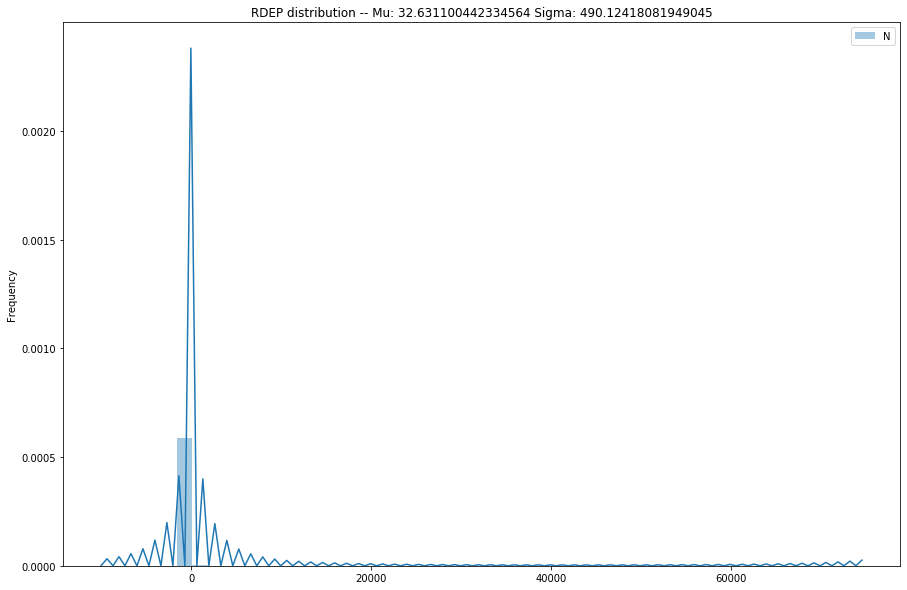

In [42]:
plt.figure(figsize=(15,10))

sns.distplot(df_main[df_main.RDEP.notnull()].RDEP.values); 

plt.legend('Normal distribution')
plt.ylabel('Frequency')
plt.title('RDEP distribution -- Mu:' + ' ' + str(mu) + ' ' + 'Sigma:' + ' ' + str(sigma) )

        * RMED Variable

In [43]:
(mu, sigma) = stats.norm.fit(df_main[df_main.RMED.notnull()].RMED.values) 

Text(0.5, 1.0, 'RMED distribution -- Mu: 51.27361302286808 Sigma: 28098.82762067032')

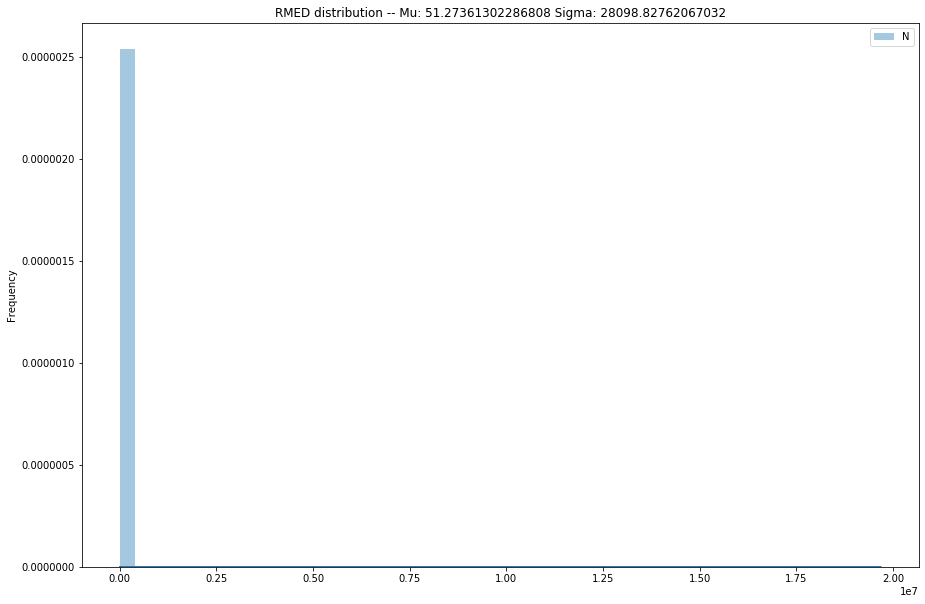

In [44]:
plt.figure(figsize=(15,10))

sns.distplot(df_main[df_main.RMED.notnull()].RMED.values); 

plt.legend('Normal distribution')
plt.ylabel('Frequency')
plt.title('RMED distribution -- Mu:' + ' ' + str(mu) + ' ' + 'Sigma:' + ' ' + str(sigma) )

* Outliers Classification

        * Number of outliers per row column

In [45]:
val = 'Number of Outliers'

df_main[val] = 0

        * Non-Outlier Ranges (Expert Provided) (Used inside classify_outliers function! In here only for display purpose)

In [46]:
ranges = {}

ranges['CALI'] = [0, 30]

ranges['NPHI'] = [0.1, 0.65] 

ranges['RHOB'] = [1, 4] 

ranges['GR'] = [0, 200]

ranges['DTC'] = [40, 200]

ranges['RDEP'] = [0.0001, 6000] 

ranges['RMED'] = [0.0001, 6000] 

        * Filling in the Numbers of Outliers Column

In [47]:
multiprocessing.set_start_method('spawn', True)

start_time = time.time()

NUM_CORES = 60

df_chunks_out_count = np.array_split(df_main, NUM_CORES)

with multiprocessing.Pool(NUM_CORES) as pool:

    df_main = pd.concat(pool.map(multi_df.classify_outliers, df_chunks_out_count), ignore_index=True)

print(str(round((time.time() - start_time)/60,1)) + ' minutes taken') 

0.4 minutes taken


        * Dropping Outliers

In [48]:
start_time = time.time()

NUM_CORES = 60

df_chunks_out_count = np.array_split(df_main, NUM_CORES)

with multiprocessing.Pool(NUM_CORES) as pool:

    df_main = pd.concat(pool.map(multi_df.remove_outliers_class, df_chunks_out_count), ignore_index=True)

print(str(round((time.time() - start_time)/60,1)) + ' minutes taken') 

0.1 minutes taken


In [49]:
len(df_main)  # number of samples

2893654

* Null Values Analysis

        * Raw Count

In [50]:
columns = df_main.columns.to_list()

columns.remove('LITHOLOGY_GEOLINK')

columns.remove('DEPTH')

columns.remove('WELL_NAME')

columns.remove('Number of Outliers')

Text(0.5, 1.0, 'Total missing values (Not a Number)')

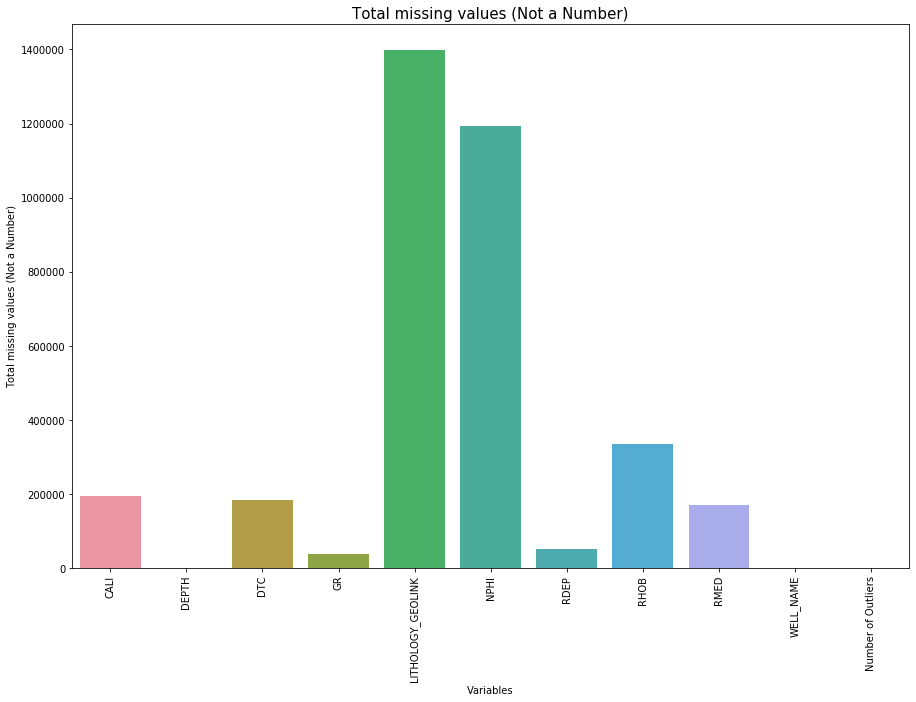

In [51]:
plt.figure(figsize=(15,10))

sns.barplot(x=df_main.isnull().sum().index, y=df_main.isnull().sum()) # only considering variables of interest
plt.xticks(rotation='90')
plt.xlabel('Variables', fontsize=10)
plt.ylabel('Total missing values (Not a Number)', fontsize=10) # Not counting -999,25
plt.title('Total missing values (Not a Number)', fontsize=15) # Not counting -999,25

        * Closer Look

Text(0.5, 1.0, 'Total missing values (Not a Number)')

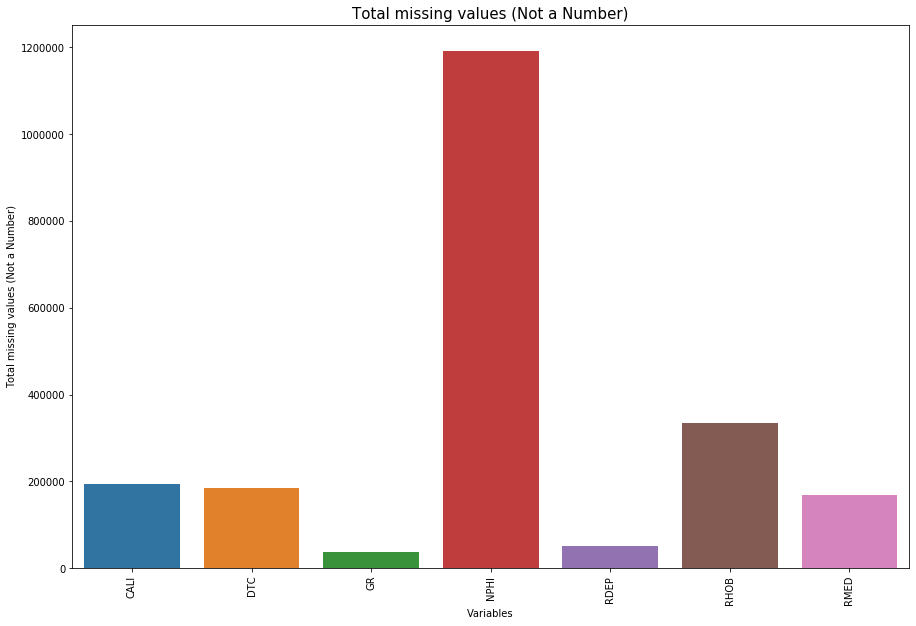

In [52]:
plt.figure(figsize=(15,10))

sns.barplot(x=df_main[columns].isnull().sum().index, y=df_main[columns].isnull().sum()) # only considering variables of interest
plt.xticks(rotation='90')
plt.xlabel('Variables', fontsize=10)
plt.ylabel('Total missing values (Not a Number)', fontsize=10) # Not counting -999,25
plt.title('Total missing values (Not a Number)', fontsize=15) # Not counting -999,25

        * Dropping Null Values of Low Percentage Presence 

In [53]:
list_nulls = ['CALI', 'RHOB', 'GR', 'DTC', 'RDEP', 'RMED']

df_main = df_main.dropna(subset=list_nulls)

Text(0.5, 1.0, 'Total missing values (Not a Number)')

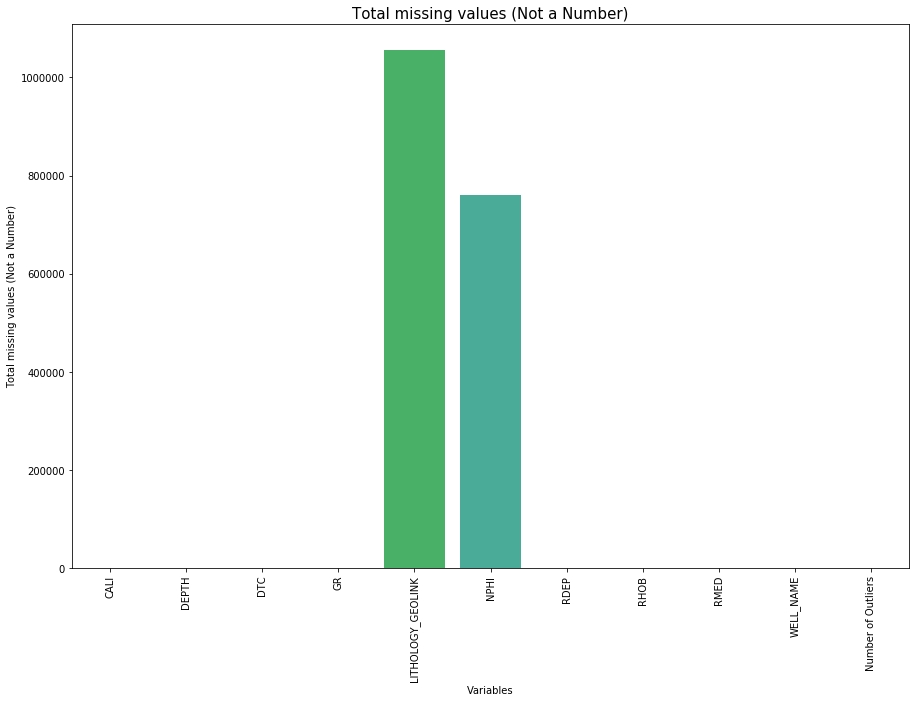

In [54]:
plt.figure(figsize=(15,10))

sns.barplot(x=df_main.isnull().sum().index, y=df_main.isnull().sum()) # only considering variables of interest
plt.xticks(rotation='90')
plt.xlabel('Variables', fontsize=10)
plt.ylabel('Total missing values (Not a Number)', fontsize=10) 
plt.title('Total missing values (Not a Number)', fontsize=15) 

In [55]:
len(df_main) # number of samples

2298400

# Checkpoint

In [56]:
path_file_lito_code = '../checkpoints/litho_code.csv.gz'

path_file_df_main = '../checkpoints/df_main.csv.gz'

litho_code.to_csv(path_file_lito_code,index=False, compression='gzip')

df_main.to_csv(path_file_df_main,index=False, compression='gzip')